# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import __version__ as sklearn_version

# Load the data

In [2]:
nba_data = pd.read_csv('../data/nba_data.csv', index_col=0)
nba_data.head(10)

,NAME,SEASON,PTS,REB,AST,BLK,STL,G,FG%,3P%,FT%,TS%,USG%,PER,WS,BPM,VORP,SALARY
0,Patrick Patterson,2017-2018,318.0,193.0,57.0,23.0,48.0,82,0.398,0.386,0.870,0.555,10.8,10.0,2.6,-1.3,0.2,4.325064e+06
1,E'Twaun Moore,2017-2018,1022.0,238.0,187.0,12.0,79.0,82,0.508,0.425,0.706,0.593,16.1,12.1,4.4,-0.2,1.2,8.680000e+06
2,Bismack Biyombo,2017-2018,468.0,468.0,66.0,95.0,21.0,82,0.520,0.000,0.650,0.556,14.9,14.1,2.9,-1.6,0.2,1.700000e+07
3,Khris Middleton,2017-2018,1652.0,429.0,328.0,21.0,119.0,82,0.466,0.359,0.884,0.577,24.6,17.4,6.9,0.4,1.8,1.752069e+07
4,Cory Joseph,2017-2018,649.0,263.0,260.0,18.0,80.0,82,0.424,0.353,0.745,0.503,14.8,11.0,3.1,-1.2,0.5,7.472500e+06
5,Jordan Clarkson,2017-2018,1124.0,217.0,221.0,6.0,58.0,81,0.451,0.352,0.800,0.542,26.5,16.4,3.0,-1.9,0.1,1.250000e+07
6,Thaddeus Young,2017-2018,955.0,512.0,152.0,36.0,135.0,81,0.487,0.320,0.598,0.528,17.3,14.8,5.5,1.5,2.3,1.250000e+07
7,Dwight Howard,2017-2018,1347.0,1012.0,105.0,131.0,48.0,81,0.555,0.143,0.574,0.577,24.2,20.5,6.8,-0.3,1.1,2.375224e+07
8,Jeremy Lamb,2017-2018,1033.0,324.0,186.0,32.0,61.0,80,0.457,0.370,0.861,0.559,22.4,17.0,4.9,0.9,1.5,7.000000e+06
9,Bojan Bogdanovic,2017-2018,1141.0,270.0,119.0,8.0,55.0,80,0.474,0.402,0.868,0.605,19.0,13.9,5.4,-0.7,0.8,1.050000e+07


# Train/Test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(nba_data.drop(columns='SALARY'), nba_data.SALARY, test_size = 0.3, random_state=77)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((110, 17), (48, 17), (110,), (48,))

Here I split the data into 2 groups, training data and testing data and also split those two groups into two more groups, features and labels. The featues are the player statistics that will be used to predict the label which in this case is the salary the player earned the year those stats were recorded. The training data will be used to train the models while the testing data will be used to test those models. I also checked the shape of the 4 groups of data to ensure they are correct.

In [5]:
name_and_season_list = ['NAME', 'SEASON']
name_and_season_train = X_train[name_and_season_list]
name_and_season_test = X_test[name_and_season_list]
X_train.drop(columns=name_and_season_list, inplace=True)
X_test.drop(columns=name_and_season_list, inplace=True)
X_train.shape, X_test.shape

((110, 15), (48, 15))

Here I saved the 'NAME' and "SEASON' columns from the train and test data. Then I removed those columns from the train and test data and once again checked the shape of these two groups.

In [6]:
X_train.dtypes

PTS     float64
REB     float64
AST     float64
BLK     float64
STL     float64
G         int64
FG%     float64
3P%     float64
FT%     float64
TS%     float64
USG%    float64
PER     float64
WS      float64
BPM     float64
VORP    float64
dtype: object

In [7]:
X_test.dtypes

PTS     float64
REB     float64
AST     float64
BLK     float64
STL     float64
G         int64
FG%     float64
3P%     float64
FT%     float64
TS%     float64
USG%    float64
PER     float64
WS      float64
BPM     float64
VORP    float64
dtype: object

This ensures that all the features in the train and test groups are numeric.

# Baseline performance model

I will start off by first using the mean of the salaries in the training data as a predictor and determining how good this "model" is at predicting.

In [8]:
dummy_mean_reg = DummyRegressor(strategy='mean')
dummy_mean_reg.fit(X_train, y_train)

# this is equal to the mean of the salaries in the training data
mean_salary = dummy_mean_reg.constant_
print('Mean of salaries in training data:', mean_salary)

Mean of salaries in training data: [[13713664.98878788]]


In [9]:
y_pred_train = dummy_mean_reg.predict(X_train)
y_pred_test = dummy_mean_reg.predict(X_test)

# R^2: measure of the proportion of variance in the dependent variable (salary) that is predicted by the model
r_squared_train = r2_score(y_train, y_pred_train)
print('R^2 (actual and predicted training salaries):', r_squared_train)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

R^2 (actual and predicted training salaries): 0.0
R^2 (actual and predicted testing salaries): -0.0011446221634241471


In [10]:
# MAE: average of the absolute errors
MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean absolute error (actual and predicted training salaries):', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean absolute error (actual and predicted testing salaries):', MAE_test)

Mean absolute error (actual and predicted training salaries): 7067479.767663912
Mean absolute error (actual and predicted testing salaries): 6951335.557159091


In [11]:
# RMSE: square root of average of the square of the errors
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)
print('Root mean squared error (actual and predicted training salaries):', RMSE_train)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('Root mean squared error (actual and predicted testing salaries):', RMSE_test)

Root mean squared error (actual and predicted training salaries): 8290153.791310435
Root mean squared error (actual and predicted testing salaries): 8507852.202054001


The R^2 score between the actual training salaries and the predicted training salaries, which is just the mean of the actual training salaries, is zero. This makes sense. However, the R^2 between the actual testing salaries and the predicted testing salaries is below zero. This also makes sense since R^2 essentially compares the model its scoring with a mean model.

As for mean absolute errors indicate that the dummy mean model was off by about \\$7 million while the root mean squared errors indicate that the model was of by over \\$8 million. These are huge given that the average salary of players in the training group is \\$13 million.

So it turns out that this model, which is just to guess that the salaries of the test group are the mean of the salaries in the train group, is not accurate at all.

# Linear regression models

### sklearn's Linear Regression model

In [12]:
lin_reg = LinearRegression(normalize=False, n_jobs=-1)
lin_reg.fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

r_squared_train = r2_score(y_train, y_pred_train)
print('R^2 (actual and predicted training salaries):', r_squared_train)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

R^2 (actual and predicted training salaries): 0.6214726671720141
R^2 (actual and predicted testing salaries): 0.38929253413435605


In [13]:
# adjusted R^2: takes into consideration the model's degrees of freedom (amount of features)

# function to calculate adjusted R^2
def adjusted_r2(r2, n, p):
    adj_r_squared = 1-((1-r2)*((n-1)/(n-p-1)))
    return adj_r_squared

# n is the number of labels in the data
n_train = len(X_train)
n_test = len(X_test)

# p is the number of features in the data (both equal)
p_train = len(X_train.columns)
p_test = len(X_test.columns)

# adjusted R^2
adj_r_squared_train = adjusted_r2(r_squared_train, n_train, p_train)
print('Adjusted R^2 (actual and predicted training data):', adj_r_squared_train)

adj_r_squared_test = adjusted_r2(r_squared_test, n_test, p_test)
print('Adjusted R^2 (actual and predicted testing data):', adj_r_squared_test)

Adjusted R^2 (actual and predicted training data): 0.5610693693803143
Adjusted R^2 (actual and predicted testing data): 0.10302340950983546


In [14]:
MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean absolute error (actual and predicted training salaries):', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean absolute error (actual and predicted testing salaries):', MAE_test)

Mean absolute error (actual and predicted training salaries): 3993532.991870239
Mean absolute error (actual and predicted testing salaries): 4959487.833597653


In [15]:
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)
print('Root mean squared error (actual and predicted training salaries):', RMSE_train)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('Root mean squared error (actual and predicted testing salaries):', RMSE_test)

Root mean squared error (actual and predicted training salaries): 5100481.886511694
Root mean squared error (actual and predicted testing salaries): 6644895.293701228


The linear regression model performed much better than the dummy regression model in all three metrics, as expected. The R^2 for the test salaries was approximately 0.39, which is certainly better but it could be improved. The adjusted R^2, which takes into consideration the model's degrees of freedom was approximately 0.1. This confirms that the model need improvement.

The MAE and RMSE for the testing salaries were approximately \\$5 million and \\$6.6 million respectively. This is much better than the mean model but that is still a lot of money.

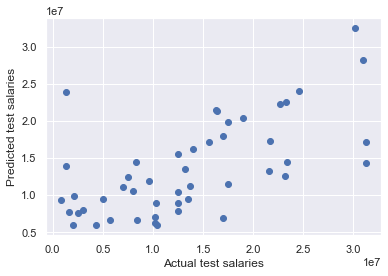

In [16]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual test salaries')
plt.ylabel('Predicted test salaries')
plt.show()

This scatter plot shows how well the predictions match the actual results. The x-axis represents the salaries in the test group while the y-represents the predicted salaries of the test group.

There is certainly a positive correlation between the two groups. However, there are a large set of salaries that were predicted to be much lower than what they actually are. For example, in the far right of the graph there is a point that represents an actual salary of about \\$31 million that was predicted to be just shy of \\$15 million.

There was also one salary that was predicted to be much higher than it actually was. The point on the top left was predicted to be about \\$24 million when it was actually about \\$1 million. This is a massive difference.

### sklearn's Linear Regression model on scaled data

In [17]:
# scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# linear regression model
lin_reg = LinearRegression(normalize=False, n_jobs=-1)
lin_reg.fit(X_train_scaled, y_train)

# predicted salaries
y_pred_train = lin_reg.predict(X_train_scaled)
y_pred_test = lin_reg.predict(X_test_scaled)

r_squared_train = r2_score(y_train, y_pred_train)
print('R^2 (actual and predicted training salaries):', r_squared_train)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

R^2 (actual and predicted training salaries): 0.6214726671720141
R^2 (actual and predicted testing salaries): 0.38929253413436304


In [18]:
# n is the number of labels in the data
n_train = len(X_train)
n_test = len(X_test)

# p is the number of features in the data (both equal)
p_train = len(X_train.columns)
p_test = len(X_test.columns)

# adjusted R^2
adj_r_squared_train = adjusted_r2(r_squared_train, n_train, p_train)
print('Adjusted R^2 (actual and predicted training data):', adj_r_squared_train)

adj_r_squared_test = adjusted_r2(r_squared_test, n_test, p_test)
print('Adjusted R^2 (actual and predicted testing data):', adj_r_squared_test)

Adjusted R^2 (actual and predicted training data): 0.5610693693803143
Adjusted R^2 (actual and predicted testing data): 0.10302340950984568


In [19]:
MAE_train = mean_absolute_error(y_train, y_pred_train)
print('Mean absolute error (actual and predicted training salaries):', MAE_train)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('Mean absolute error (actual and predicted testing salaries):', MAE_test)

Mean absolute error (actual and predicted training salaries): 3993532.9918702412
Mean absolute error (actual and predicted testing salaries): 4959487.833597622


In [20]:
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)
print('Root mean squared error (actual and predicted training salaries):', RMSE_train)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('Root mean squared error (actual and predicted testing salaries):', RMSE_test)

Root mean squared error (actual and predicted training salaries): 5100481.886511694
Root mean squared error (actual and predicted testing salaries): 6644895.29370119


Scaling the data using StandardScaled before using the same Linear Regression model produced negligible differences in the R^2 metric and the RMSE metric for the test salaries. Every other metric was identical.

### sklearn's Ridge regression model with scaled data using cross validation

In [21]:
# scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ridge regression model
ridge = Ridge()

# alpha hyperparameter
param_grid = {'alpha':np.arange(0,100,0.1)}
ridge_cv = GridSearchCV(ridge, param_grid=param_grid, cv=5, n_jobs=-1)
ridge_cv.fit(X_train_scaled, y_train)

print('Best alpha:', ridge_cv.best_params_['alpha'])
print('R^2 of best alpha:', ridge_cv.best_score_)

Best alpha: 13.9
R^2 of best alpha: 0.43278602646324843


GridSearchCV determined that the alpha hyperparameter that allowed the ridge regression model to perform the best was alpha=13.9. This model had an R^2 of about 0.433 for the training data. The linear regression model performed better than this model with the training data.

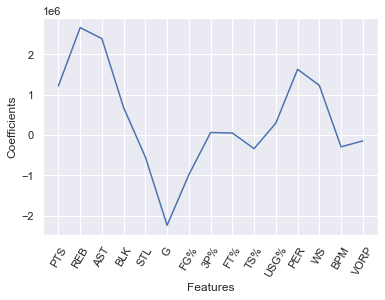

In [22]:
ridge = Ridge(alpha=13.9)

features = X_train.columns
ridge_coef = ridge.fit(X_train_scaled, y_train).coef_

plt.plot(range(len(features)), ridge_coef)
plt.xticks(range(len(features)), features, rotation=60)
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.show()

The ridge regression model chooses a coefficient for each feature based on how important that feature is. The larger the coefficient, the more important it is. It determined that total rebounds (REB) are the most important feature. This is somewhat surprising but rebounds have always been the most unheralded of the basic statistics. Total assists (AST) are next. Players that distribute the ball very well are typicl=ally compenstated very well. The next important is games played (G). Since it's in the negative that means that as the games played in a season increases, the salary of the player decreases. This makes sense since most of the high salary players are also at least All-star level players which means they tend to take more games off due to "load management" or "injury management".

Interestingly, this model determined that 3-point field goal percentage (3P%) and free throw percentage (FT%) are unimportant enough to get a near-zero coefficient. Given the leagues shift towards a more 3-point centric offense, I would think this would be much higher.

In [23]:
ridge.fit(X_train_scaled, y_train)

y_pred_test = ridge.predict(X_test_scaled)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

adj_r_squared_test = adjusted_r2(r_squared_test, n_test, p_test)
print('\nAdjusted R^2 (actual and predicted testing data):', adj_r_squared_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('\nMean absolute error (actual and predicted testing salaries):', MAE_test)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('\nRoot mean squared error (actual and predicted testing salaries):', RMSE_test)

R^2 (actual and predicted testing salaries): 0.4230847569155054

Adjusted R^2 (actual and predicted testing data): 0.1526557367196486

Mean absolute error (actual and predicted testing salaries): 4715319.277424536

Root mean squared error (actual and predicted testing salaries): 6458438.587896661


The ridge regression model performed a little bit better than the linear regression model. The R^2 and adjusted R^2 for the testing data for the linear regression model was approximately 0.389 and 0.103, respectively. The MAE and RMSE for the testing data for the linear regression model was approximately \\$4,959,487.8 and \\$6,644,895.3, respectively. There were imporvements for all four of these metrics.

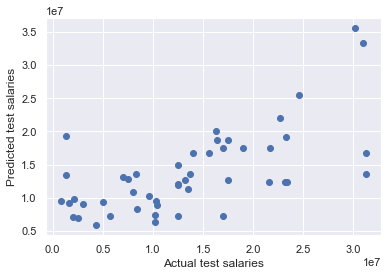

In [24]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual test salaries')
plt.ylabel('Predicted test salaries')
plt.show()

This scatter plot shows how well the predictions match the actual results for the ridge regression model. The x-axis represents the salaries in the test group while the y-represents the predicted salaries of the test group.

Juat as with the linear regression results, there seems to be a positive correlation between the predicted and actual salaries. Also, the points on this plot seems slighlty tighter than the linear regression model which makes since given the better metrics.

The far right point that I pointed out in the first graph was predicted to be similar. That salary of about \\$31 million that was predicted to be just shy of \\$15 million. However, the other point I focused on was the one that was top left most. Where in the previous model that point was predicted to be about \\$24 million when it was actually about \\$1 million, this model predicted it to be about just under \\$20 million. This difference isn't as massive, but still quite significant.

### sklearn's Lasso regression model with scaled data using cross validation

In [25]:
# scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# lasso regression model
lasso = Lasso()

# alpha hyperparameter
param_grid = {'alpha':np.arange(0,100,0.1)}
lasso_cv = GridSearchCV(lasso, param_grid=param_grid, cv=5, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

print('Best alpha:', lasso_cv.best_params_['alpha'])
print('R^2 of best alpha:', lasso_cv.best_score_)

Best alpha: 99.9
R^2 of best alpha: 0.3745317665440984


In [26]:
pd.DataFrame(lasso_cv.cv_results_)[['param_alpha', 'params', 'mean_test_score', 'rank_test_score']].tail()

,param_alpha,params,mean_test_score,rank_test_score
995,99.5,{'alpha': 99.5},0.374531,5
996,99.6,{'alpha': 99.60000000000001},0.374531,4
997,99.7,{'alpha': 99.7},0.374532,3
998,99.8,{'alpha': 99.80000000000001},0.374532,2
999,99.9,{'alpha': 99.9},0.374532,1


GridSearchCV determined that the alpha hyperparameter that allowed the lasso regression model to perform the best was alpha=99.9. This model had an R^2 of about 0.375 for the training data. The alpha was the maximum value of all the possible options I gave it to try. Also the next best 4 scores, which are 99.8, 99.7, 99.6, and 99.5, have virtually identical scores. This seems to suggest that this is about as good as the model will perform no matter what other alpha values I use. That being said, the linear regression model and the ridge regression model both performed better than this model.

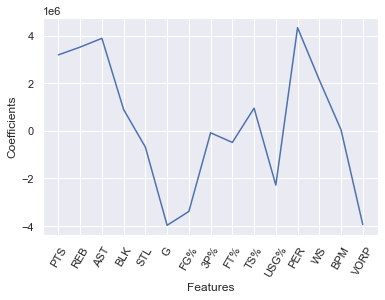

In [27]:
lasso = Lasso(alpha=99.9)

features = X_train.columns
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

plt.plot(range(len(features)), lasso_coef)
plt.xticks(range(len(features)), features, rotation=60)
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.show()

The lasso model had some different results in terms of determining the importance of each feature. According to this model, player efficiency rating (PER) is the most important feature. This is a way to quantify a player's overall offensive production so this makes sense. The next three most important are total assists (AST), games played (G), and value over replacement player (VORP). All three of these had the same coefficient magnitude but the G and VORP coefficients were negative while the AST coefficient was positive. The most obvious difference between the lasso and ridge coefficients is the one for VORP. The lasso model has a -4 coefficient for VORP but the ridge model had a near-zero coefficient. Typically the best players have a high VORP stat so the coefficients for both of these models is unexpected. Both models, however, agreed on games played. Beyond these observations, both models produced similar coefficients.

In [28]:
lasso.fit(X_train_scaled, y_train)

y_pred_test = lasso.predict(X_test_scaled)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

adj_r_squared_test = adjusted_r2(r_squared_test, n_test, p_test)
print('\nAdjusted R^2 (actual and predicted testing data):', adj_r_squared_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('\nMean absolute error (actual and predicted testing salaries):', MAE_test)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('\nRoot mean squared error (actual and predicted testing salaries):', RMSE_test)

R^2 (actual and predicted testing salaries): 0.3893765573278153

Adjusted R^2 (actual and predicted testing data): 0.10314681857522867

Mean absolute error (actual and predicted testing salaries): 4958987.24138808

Root mean squared error (actual and predicted testing salaries): 6644438.1644213535


Across the board the lasso regression model performed worse than the ridge regression model and only marginally better than the linear regression model.

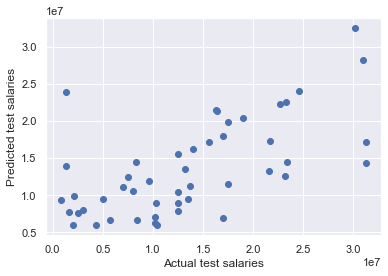

In [29]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual test salaries')
plt.ylabel('Predicted test salaries')
plt.show()

The scatter plot for the actual and predicted test salaries is also very similar to the one produced by the linear regression model.

### sklearn's ElasticNet regression model with scaled data using cross validation

In [30]:
# scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# lasso regression model
elastic_net = ElasticNet()

# alpha hyperparameter
param_grid = {'alpha':np.arange(0,100,0.1), 'l1_ratio':np.arange(0,1,0.1)}
elastic_net_cv = GridSearchCV(elastic_net, param_grid=param_grid, cv=5, n_jobs=-1)
elastic_net_cv.fit(X_train_scaled, y_train)

print('Best combination of alpha and l1_ratio:', elastic_net_cv.best_params_)
print('R^2 of best combination:', elastic_net_cv.best_score_)

Best combination of alpha and l1_ratio: {'alpha': 1.6, 'l1_ratio': 0.9}
R^2 of best combination: 0.43278377105347204


The elastic net model had an R^2 for the training data that is negligibly worse than the ridge regression model, which has thus far been the best performing model.

In [31]:
elastic_net = ElasticNet(alpha=1.6, l1_ratio=0.9)
elastic_net.fit(X_train_scaled, y_train)

y_pred_test = elastic_net.predict(X_test_scaled)

r_squared_test = r2_score(y_test, y_pred_test)
print('R^2 (actual and predicted testing salaries):', r_squared_test)

adj_r_squared_test = adjusted_r2(r_squared_test, n_test, p_test)
print('\nAdjusted R^2 (actual and predicted testing data):', adj_r_squared_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
print('\nMean absolute error (actual and predicted testing salaries):', MAE_test)

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('\nRoot mean squared error (actual and predicted testing salaries):', RMSE_test)

R^2 (actual and predicted testing salaries): 0.4226972406137045

Adjusted R^2 (actual and predicted testing data): 0.15208657215137844

Mean absolute error (actual and predicted testing salaries): 4710168.546731311

Root mean squared error (actual and predicted testing salaries): 6460607.30343262


Just as for the R^2 for the training data, the metrics for the testing data were also very close. The R^2, adjusted R^2, and the RMSE for the elastic net model were only slighly worse. It's MAE was better but again the difference wasn't by much.

# Final model selection

**metrics** | Linear regression | Ridge regression | Lasso regression | ElasticNet regression
:-----------|:-----------------:|:----------------:|:----------------:|:--------------------:
**R^2 (train)** | 0.6214726671720141 | 0.43278602646324843 | 0.3745317665440984 | 0.43278377105347204
**R^2 (test)** | 0.38929253413435605 | 0.4230847569155054 | 0.3893765573278153 | 0.4226972406137045
**Adjusted R^2 (test)** | 0.10302340950983546 | 0.1526557367196486 | 0.10314681857522867 | 0.15208657215137844
**Mean absolute error (test)** | 4959487.833597653 | 4715319.277424536 | 4958987.24138808 | 4710168.546731311
**Root mean squared error (test)** | 6644895.293701228 | 6458438.587896661 | 6644438.1644213535 | 6460607.30343262

The two best performing models were the ridge regression model and the elastic net regression model. However, the ridge regression model had slighly better metrics so this will be the model I select.

# Saving the best model

In [32]:
pipeline = Pipeline([('scaler', StandardScaler()),('ridge', Ridge(alpha=13.9))])
pipeline.fit(X_train, y_train)

pipeline.score(X_test, y_test)

0.4230847569155054

This confirms that the pipeline produced the same results as the ridge regression model created earlier in this notebook.

In [33]:
best_model = pipeline
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

with open('../models/nba_contract_model.pkl', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)